In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
from IPython.display import HTML
import time
import datetime
import json

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon

import seaborn as sns
from sklearn.model_selection import train_test_split

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '\\'.join(parent_path.split('\\')[:-1]) 

#Check if path exists
path_common_scripts = os.path.join(path_common,'Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'hyper_parameters.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']




#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
LOSS_TYPE = experiment_params['loss_type']
BATCH_SIZE_TR = experiment_params['training_batch_size']
BATCH_SIZE_TE = experiment_params['testing_batch_size']
BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']
ROLLOUT_TIMESTEPS = experiment_params['rollout_timesteps']
ROLLOUT_TIMESTEPS_VIS = experiment_params['rollout_timesteps_vis']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']


# Folder description to distinguish between experiment runs
desc = "ntr="+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_btr="+str(BATCH_SIZE_TR)
desc = desc +"_date="+str(current_time)

#Set seed
SEED = 4893
desc = desc +"seed="+str(SEED)

np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.random.set_seed(SEED)

Current_date: 2021-04-09 01:17:46.410604


In [3]:
base = os.getcwd()
if(not os.path.exists(base)):
    os.makedirs(base)
    
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
    
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
    
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)
    
#Save the used parameters as a json file into this folder
with open(os.path.join(path_saves,'specification.json'), 'w') as fp:
    json.dump(test_spec, fp)
    
#Path to Datasets
path_dataset = os.path.abspath('..\\..\\..\\..')
path_dataset = os.path.join(path_dataset,'Data')

if(not os.path.exists(path_dataset)):
    print("Data folder does not exist.")

In [4]:
# Import model
import GNNModels_tf2 as models
# Import training plot
from TrainingPlot import training_plot, training_plot_log_scale
# Import rollout plot
from RolloutPlot import rollout_plot, rollout_plot_log_scale
# Import functions for creating graph
from Graph_creator_functions import rigid_graph_from_pos_all, rigid_graph_from_pos_closest
# Import data loader module
from PushDatasetLoad import load_dataset, collect_trajectory_indeces, create_train_valid_test, collect_states, remove_effector, outlier_remover
# Import Dataset Feeder function
from PushDatasetFeed import DataFeeder
# Import simulation functions
from PushDatasetSimulator import PushDatasetSimulator
# Import function for experiments
from LossFunctions import velocity_loss_single_step, make_all_runnable_in_session, rollout_loss_mean, rollout_loss_max, rollout_error
# Import visualisation functions
from VisualisationFunctions import visualise_trajectory, visualise_groundtruth

## Data loading:
In this section of the code we load the data. Split the trajectories into training, validation and testing sets.

In [5]:
# Set paths:
file_1 = os.path.join(path_dataset, "Rect1_Data100ms_1_of_2_flagged.csv")
file_2 = os.path.join(path_dataset, "Rect1_Data100ms_2_of_2_flagged.csv")
# Load dataset
df_set_1, STEP_SIZE = load_dataset(file_1)
df_set_2, STEP_SIZE = load_dataset(file_2)

# Collect trajectory indeces
VEL_ACCS = ['10.0-0.0','20.0-0.0','50.0-0.0']
trajectory_indeces,df_set_1 = collect_trajectory_indeces(df_set_1, ts = STEP_SIZE, vel_accs = VEL_ACCS)

_, df_set_2 = collect_trajectory_indeces(df_set_2, ts = STEP_SIZE, vel_accs = VEL_ACCS)
# Split indeces so that no trajectory is contained in both train, validation or test datasets
tr_inds, va_inds, te_inds = create_train_valid_test(trajectory_indeces, 0.25)

# Collect trajectories from these 
df_tr_1 = collect_states(tr_inds, df_set_1)
df_tr_2 = collect_states(tr_inds, df_set_2)
df_va_1 = collect_states(va_inds, df_set_1)
df_va_2 = collect_states(va_inds, df_set_2)
df_te_1 = collect_states(te_inds, df_set_1)
df_te_2 = collect_states(te_inds, df_set_2)

# Remove Outliers
df_tr_1, df_tr_2 = outlier_remover(df_tr_1, df_tr_2, 0.001)
df_va_1, df_va_2 = outlier_remover(df_va_1, df_va_2, 0.001)
df_te_1, df_te_2 = outlier_remover(df_te_1, df_te_2, 0.001)


df_dict = {"tr_1":df_tr_1, 
           "tr_2":df_tr_2, 
           "va_1":df_va_1,
           "va_2":df_va_2,
           "te_1":df_te_1,
           "te_2":df_te_2,}

# Train

In [6]:
# Create the model.
model = models.EncodeProcessDecode(ind_layer_numbers = IND_LAYER_NUMBER,
                                   ind_latent_unit_size = IND_LATENT_SIZE,
                                   ful_layer_numbers = FUL_LAYER_NUMBER,
                                   ful_latent_unit_size = FUL_LATENT_SIZE,
                                   node_output_size=2,
                                   edge_output_size=2,
                                   global_output_size=1)



LEARNING_RATE = model_params['learning_rate']
optimizer = snt.optimizers.Adam(LEARNING_RATE)

In [7]:
def update_step(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, 1)
        # Only Nodes
        outputs_tr_nodes = outputs_tr[0].nodes
        targets_tr_nodes = targets_tr.nodes
        # Loss
        loss_tr = velocity_loss_single_step(targets_tr, outputs_tr[0])
    
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_tr, gradients

def test_step(inputs, targets):
    outputs = model(inputs, 1)
    # Only Nodes
    output_nodes = outputs[0].nodes
    target_nodes = targets.nodes
    
    # Loss
    loss = velocity_loss_single_step(targets, outputs[0])
    
    return loss


def update_step_rollout(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        # Predict trajectory using the model
        pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs_tr, targets_tr)
        # Loss tr
        loss_tr = rollout_loss_mean(real_trajectory, pred_trajectory)
        
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return 0, loss_tr, gradients

def test_step_rollout(inputs, targets):
    # Predict trajectory using the model
    pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs, targets)
    
    # Loss
    loss = rollout_loss_mean(real_trajectory, pred_trajectory)
                        
    return loss


## Compiling loss function

In [8]:
# Setup data feeder and simulator

# One step data feeder
feeder = DataFeeder(SEED)
d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all)

# Rollout simulator feeder
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE)
# ------------------------------------------------------------------------

# Get data from feeder
X_tr_step = d["X_tr"]
Y_tr_step = d["Y_tr"]

# Get data from simulator
real, pred, i_np = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
X_tr_roll, Y_tr_roll = sim.convert_trajectories(real, pred)

# ------------------------------------------------------------------------

# Get input signature of one step input
input_signature_step = [
    utils_tf.specs_from_graphs_tuple(X_tr_step),
    utils_tf.specs_from_graphs_tuple(X_tr_step)]

# Get input signature of rollout input
input_signature_rollout = [
    [utils_tf.specs_from_graphs_tuple(X_tr_roll[0])]*ROLLOUT_TIMESTEPS,
    [utils_tf.specs_from_graphs_tuple(Y_tr_roll[0])]*ROLLOUT_TIMESTEPS]

# ------------------------------------------------------------------------

# Compile the update function using the input signature for speedy code
compiled_update_step = tf.function(update_step, input_signature = input_signature_step)
compiled_update_step_rollout = tf.function(update_step_rollout, input_signature = input_signature_rollout)

In [14]:
tf.config.run_functions_eagerly(False)
# Setup logging
last_iteration = 0
logged_iterations = []
losses_step_tr = []
losses_step_va = []
losses_step_te = []

losses_roll_tr = []
losses_roll_va = []
losses_roll_te = []
gradients = []

log_every_iteration = 20

print("# (iteration number) out of max iteration, T (elapsed seconds), "
      "Ltr, "
      "Lte, "
      "Lge")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, NUM_TRAINING_ITERATIONS):
    last_iteration = iteration
    do_logging = (last_iteration % log_every_iteration == 0)
    
    

    
    
    loss_roll_tr = tf.constant([0])
    loss_step_tr = tf.constant([0])
    gradient = tf.constant([0])
    
    if LOSS_TYPE == "rollout":
        # Get training data: Rollout
        real_tr, pred_tr, i_np = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  One-step
        loss_step_tr = test_step(X_step_tr, Y_step_tr)
        # Do one tick of training    
        outputs_tr, loss_roll_tr, gradient = compiled_update_step_rollout(X_roll_tr, Y_roll_tr)
        
    elif LOSS_TYPE == "step":
        d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all,
                    te_and_va = False)
        
        # Get data from feeder
        X_step_tr = d["X_tr"]
        Y_step_tr = d["Y_tr"]

        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
        
    else:
        # Get training data: Rollout
        real_tr, pred_tr, i_np = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  Rollout
        loss_roll_tr = test_step_rollout(X_roll_tr, Y_roll_tr)
        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
    
    
    # Don't log at every iteration
    if do_logging:
        # Get validation and test data: Rollout
        real_va, pred_va, _ = sim.get_trajectories(df_va_1, df_va_2, BATCH_SIZE_GE, rigid_graph_from_pos_all)
        X_roll_va, Y_roll_va = sim.convert_trajectories(real_va, pred_va)
        real_te, pred_te, _ = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
        X_roll_te, Y_roll_te = sim.convert_trajectories(real_te, pred_te)
        
        # Get validation and test data: One-step
        X_step_va = X_roll_va[0]
        Y_step_va = Y_roll_va[0]
        X_step_te = X_roll_te[0]
        Y_step_te = Y_roll_te[0]      
        
        # Validation and Test: Rollout
        loss_roll_va = test_step_rollout(X_roll_va, Y_roll_va)
        loss_roll_te = test_step_rollout(X_roll_te, Y_roll_te)
        
        # Validation and Test: One-step
        loss_step_va = test_step(X_step_va, Y_step_va)
        loss_step_te = test_step(X_step_te, Y_step_te)
        
        
        # Convert losses to normal values
        loss_roll_tr = loss_roll_tr[0].numpy()
        loss_roll_va = loss_roll_va[0].numpy()
        loss_roll_te = loss_roll_te[0].numpy()
        loss_step_tr = loss_step_tr[0].numpy()
        loss_step_va = loss_step_va[0].numpy()
        loss_step_te = loss_step_te[0].numpy()
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        
        # Log data
        elapsed = time.time() - start_time
        losses_roll_tr.append(loss_roll_tr)
        losses_roll_va.append(loss_roll_va)
        losses_roll_te.append(loss_roll_te)
        
        losses_step_tr.append(loss_step_tr)
        losses_step_va.append(loss_step_va)
        losses_step_te.append(loss_step_te)
        
        gradients.append(gradient)
        logged_iterations.append(iteration)
        
        
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Step {:.6f}, Lva Step {:.6f}, Lte Step {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_step_tr, loss_step_va, loss_step_te))
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Roll {:.6f}, Lva Roll {:.6f}, Lte Roll {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_roll_tr, loss_roll_va, loss_roll_te))
        print("-----------------------------------------------------------------------------------")
    
tf.config.run_functions_eagerly(True)    

# (iteration number) out of max iteration, T (elapsed seconds), Ltr, Lte, Lge
# 00000, Max 01000, T 4.2, Ltr Step 0.000076, Lva Step 0.000062, Lte Step 0.000071
# 00000, Max 01000, T 4.2, Ltr Roll 0.000000, Lva Roll 0.000038, Lte Roll 0.000058
-----------------------------------------------------------------------------------
# 00020, Max 01000, T 12.8, Ltr Step 0.000072, Lva Step 0.000063, Lte Step 0.000082
# 00020, Max 01000, T 12.8, Ltr Roll 0.000000, Lva Roll 0.000042, Lte Roll 0.000065
-----------------------------------------------------------------------------------
# 00040, Max 01000, T 21.7, Ltr Step 0.000075, Lva Step 0.000062, Lte Step 0.000094
# 00040, Max 01000, T 21.7, Ltr Roll 0.000000, Lva Roll 0.000046, Lte Roll 0.000059
-----------------------------------------------------------------------------------
# 00060, Max 01000, T 30.6, Ltr Step 0.000112, Lva Step 0.000061, Lte Step 0.000059
# 00060, Max 01000, T 30.6, Ltr Roll 0.000000, Lva Roll 0.000044, Lte Roll 0.000046


# 00660, Max 01000, T 296.3, Ltr Step 0.000050, Lva Step 0.000033, Lte Step 0.000045
# 00660, Max 01000, T 296.3, Ltr Roll 0.000000, Lva Roll 0.000061, Lte Roll 0.000061
-----------------------------------------------------------------------------------
# 00680, Max 01000, T 305.4, Ltr Step 0.000035, Lva Step 0.000019, Lte Step 0.000029
# 00680, Max 01000, T 305.4, Ltr Roll 0.000000, Lva Roll 0.000046, Lte Roll 0.000055
-----------------------------------------------------------------------------------
# 00700, Max 01000, T 314.2, Ltr Step 0.000033, Lva Step 0.000027, Lte Step 0.000042
# 00700, Max 01000, T 314.2, Ltr Roll 0.000000, Lva Roll 0.000085, Lte Roll 0.000083
-----------------------------------------------------------------------------------
# 00720, Max 01000, T 323.0, Ltr Step 0.000023, Lva Step 0.000017, Lte Step 0.000029
# 00720, Max 01000, T 323.0, Ltr Roll 0.000000, Lva Roll 0.000030, Lte Roll 0.000049
--------------------------------------------------------------------

## Saving losses

In [15]:
def save_data(name, data):
    data = np.array(data)
    if os.path.exists(os.path.join(path_saves, name)):
        print("The file: "+ name + " already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.makedirs(os.path.join(path_saves)) 
            
        np.save(os.path.join(path_saves, name), data)

save_data("iterations", logged_iterations)
save_data("losses_step_tr", losses_step_tr)
save_data("losses_step_te", losses_step_te)
save_data("losses_step_va", losses_step_va)
save_data("losses_roll_tr", losses_roll_tr)
save_data("losses_roll_te", losses_roll_te)
save_data("losses_roll_va", losses_roll_va)
save_data("gradients", gradients)


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<IPython.core.display.Javascript object>


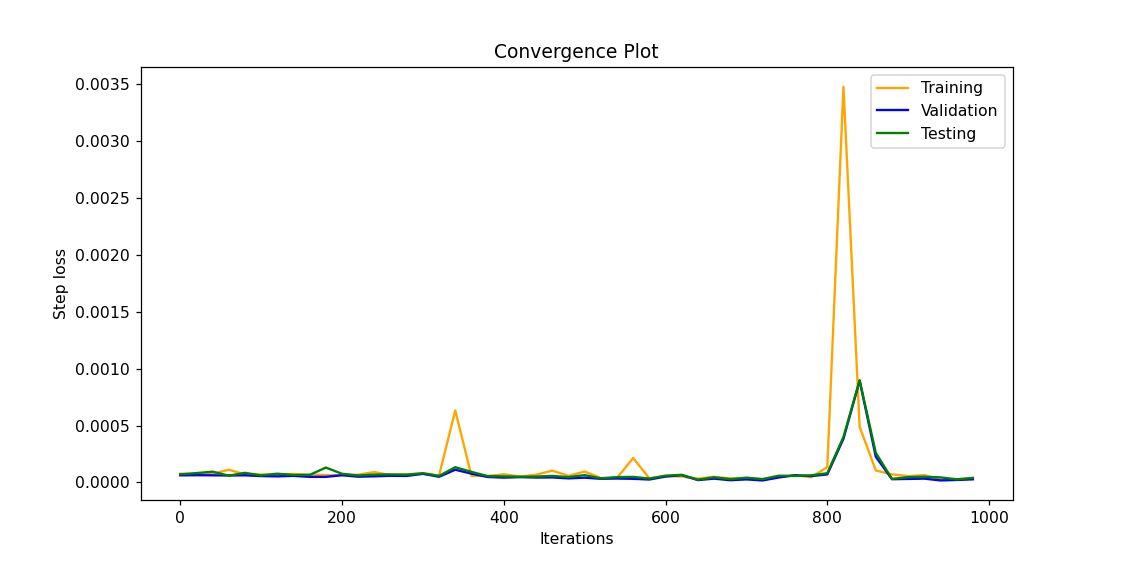

In [16]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, "StepConvergencePlot")
plt.show()

<IPython.core.display.Javascript object>


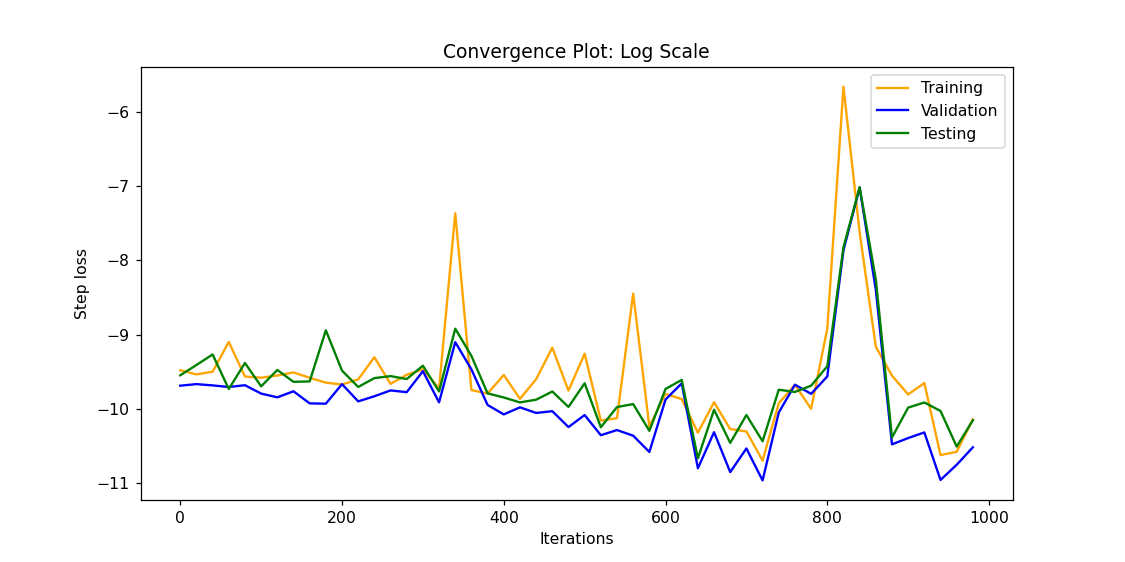

In [17]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, "StepConvergencePlotLogScale")
plt.show()

<IPython.core.display.Javascript object>


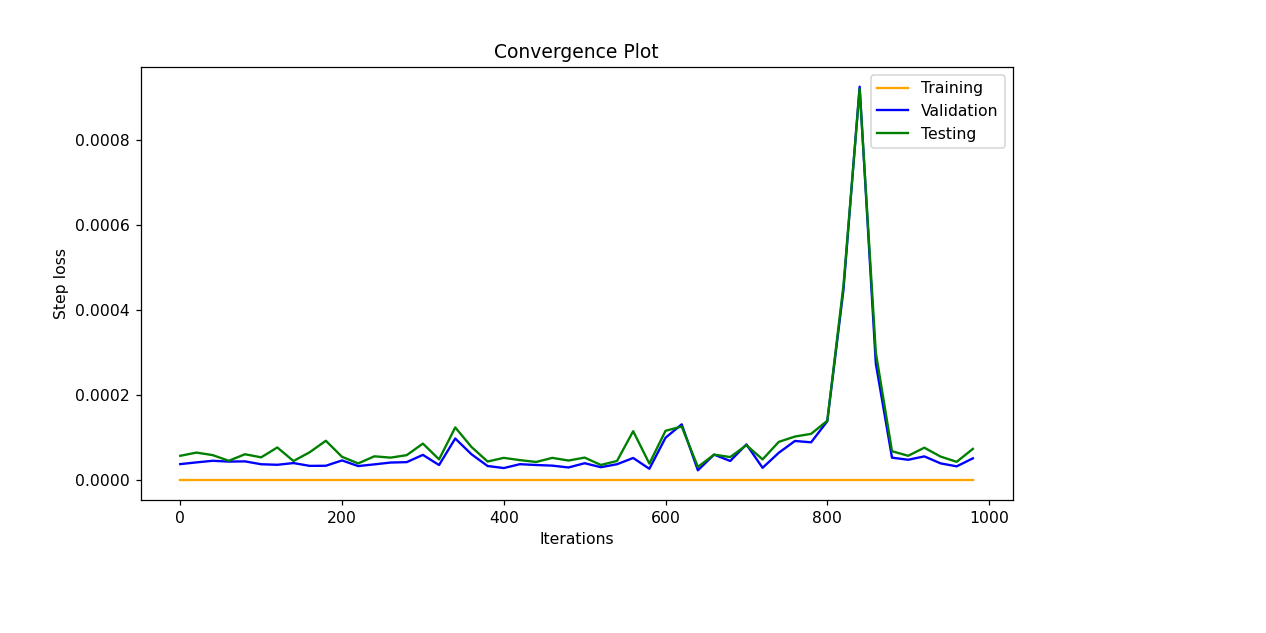

In [18]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, "RolloutConvergencePlot")
plt.show()

<IPython.core.display.Javascript object>


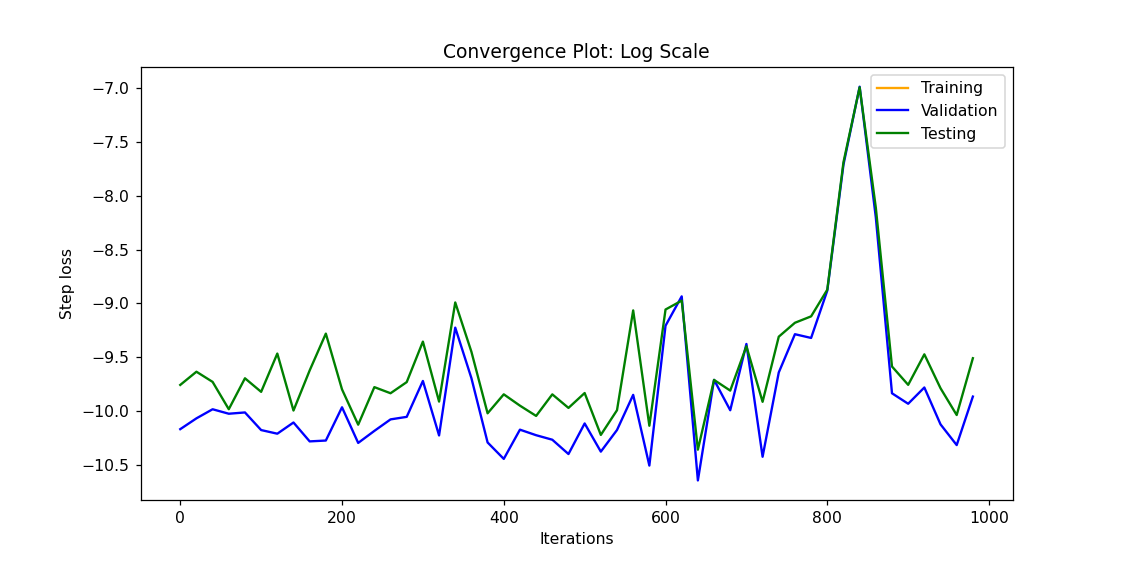

C:\Users\vbenc\Projects\Honours\Honours\Phases\Common\Scripts\TrainingPlot.py:62: RuntimeWarning: divide by zero encountered in log
  y = np.log(tr_loss)


In [19]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, "RolloutConvergencePlotLogScale")
plt.show()

## Evaluation

In [29]:
# Simulator
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS_VIS, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np = sim.get_trajectories(df_te_1, df_te_2, 1, rigid_graph_from_pos_all)
# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g,Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)
# Get error in rollout
steps, error = rollout_error(real_trajectory, pred_trajectory)
error = error + 0.000002

<IPython.core.display.Javascript object>


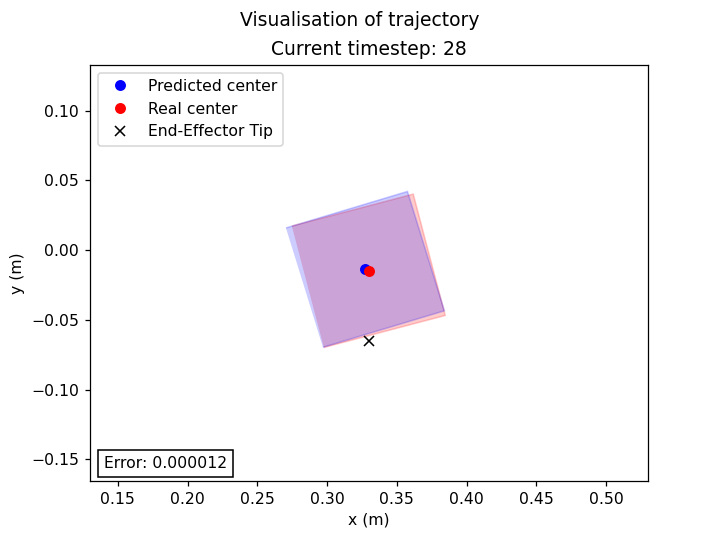

In [30]:
plt.close('all')
fig, ax, anim = visualise_trajectory(pred_trajectory, real_trajectory, ROLLOUT_TIMESTEPS_VIS)
anim.save(os.path.join(path_animations,'visualisation.gif'), writer='imagemagick', fps=60)
#plt.close('all')
#HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>


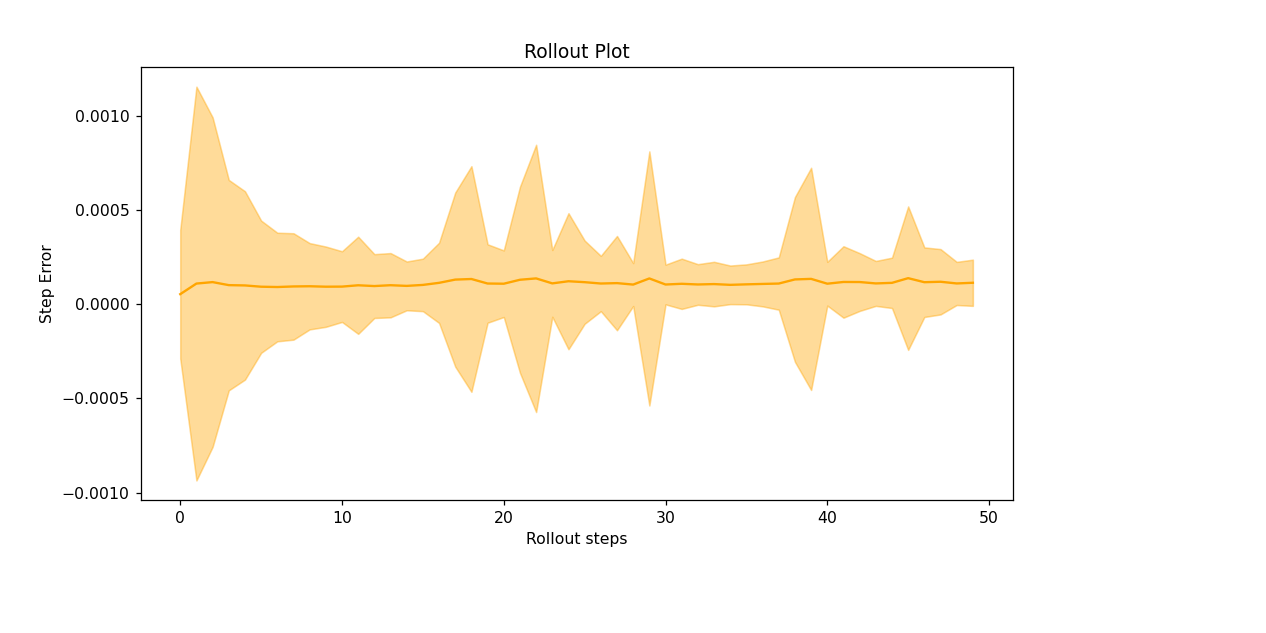

In [21]:
plt.close('all')
fig, ax = rollout_plot(steps, error, path_plots)
plt.show()

<IPython.core.display.Javascript object>


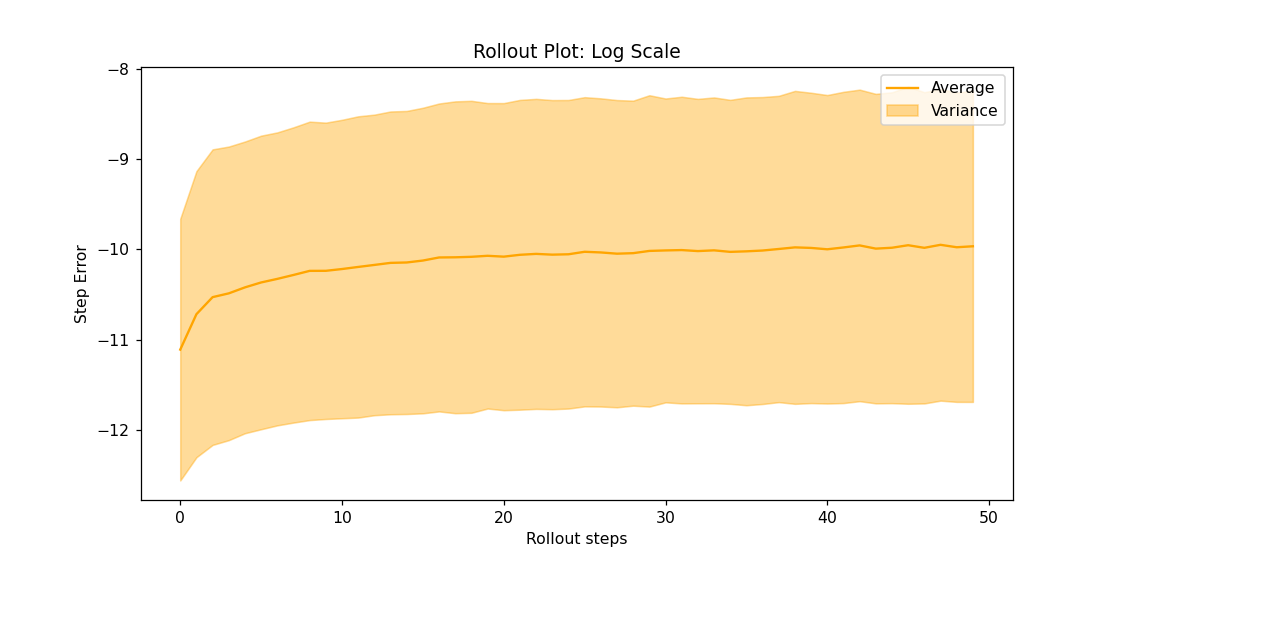

In [22]:
plt.close('all')
fig, ax = rollout_plot_log_scale(steps, error, path_plots)
plt.show()